# Distributed Memory Parallelism with OpenMP

During this exercise we will parallelize the stencil program from day 1 using OpenMP. The goal is to apply the OpenMP concepts that have been discussed in the lecture. If everything goes well, at the end of this exercise you will have a parallel version of the diffusion operator.

So let's start!

## Performance Baseline

In the first step we will see how fast our code performs and what the straightforward insertion of compiler directives (pragmas) can do.

In [1]:
import timeit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

We start by compiling the Fortran stencil2d base code (this is the code with inlining your have worked on previusly).

In [2]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report


In [3]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=base

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-base.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-base.o -o stencil2d-base.x
cp stencil2d-base.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


This created **two** executables. `stencil2d-base.x+orig` is the executable which is simply compiled and not instrumented by perftools-lite for performance profiling. `stencil2d-base.x` is an executable that has been instrumented for performance profiling and will generate a performance report at the end of execution.

Let's run the version without performance profiling to get a baseline runtime.

In [6]:
%%bash
srun -n 1 ./stencil2d-base.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.8137889E+00], \
] )


Take note of the runtime (the last value in the `data` array). This is our sequential baseline. It should be on the order of 0.8 s. As reminder, this time is only the time it takes to execute the loop over the iterations where we apply the diffusion stencil.

Note: If you feel more comfortable with C++, there is also a version available in C++. This notebook is setup to work with the Fortran version. In case you prefer to work in C++, you will have to adapt the compilation commands in this notebook with the following syntax.

In [32]:
%%bash
module load daint-gpu
module load perftools-lite

CC stencil2d-base.cpp -fopenmp -o stencil2d-base.x

INFO: creating the CrayPat-instrumented executable 'stencil2d-base.x' (lite-samples) ...OK


Note: The C++ code is run very similarly to the Fortran code, but you have to remove the `--nx`, `--ny`, ... option descriptors.

In [33]:
%%bash
srun -n 1 ./stencil2d-base.x+orig 128 128 64 1024

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[ 24, 128, 128, 64, 1024, 9.46711],
] )


## Validation

As a first step, it is always good to make sure that the code is working correctly before proceeding with any sort of parallelization or optimization. We plot the initial and final step to see that the code still produces the same result.

In [7]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('in_field.dat')
    im1 = axs[0].imshow(in_field[0, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition');

    out_field = read_field_from_file('out_field.dat')
    im2 = axs[1].imshow(out_field[0, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result');
    
    plt.show()

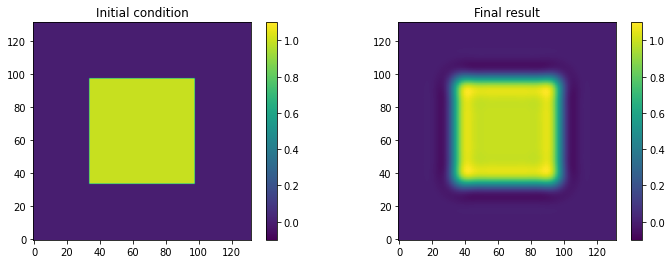

In [8]:
validate_results()

## Parallelization of the k-loop

Let's use perftools-lite to generate a performance report for the base version. This will be useful to guide our parallelization approach.

In [9]:
%%bash
srun -n 1 ./stencil2d-base.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_base.txt

CrayPat/X:  Version 7.1.1 Revision 7c0ddd79b  08/19/19 16:58:46


Take a look at the performance report in the file `report_base.txt`. Which are the lines which consume most of the runtime (hot loops)? These code regions should be the primary targets for parallelization with OpenMP.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Make a copy of the source code and name it <tt>stencil2d-kparallel.F90</tt>. Compile it (see cell below) and run it (see cell after that). For the time being, the runtime should be the same as the base version. Insert the following block of code immediately at program start to print out the number of available threads.
<code>
!$omp parallel
!$omp master
!$ write(*,*) '#threads = ', omp_get_num_threads()
!$omp end master
!$omp end parallel
</code>
Compile and run your code again. How many threads do we have available? Does the number match the number of cores?
<br>
<b>2.</b> Now use OpenMP to parallelize the <tt>k</tt>-loop. Compile the code again and execute it. Quickly check that the results are still ok (using <tt>validate_results()</tt>, see below) How fast is your code relative to the base version? What would you have expected?<br>
<b>3.</b> Generate a perftools-lite report and check what changed relative to the base version. What are the places that consume most of the runtime now?<br>
<b>4.</b> Rerun for <tt>nz</tt>=1, 24, 25, 48, 64 ,480 and inspect the perftools-lite report for each of these settings. Look at how the relative distribution of runtime changes in table 2. Can you guess what is happening? Why is <tt>nz</tt>=64 not an ideal setting?<br>
</div>

In [14]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=kparallel

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-kparallel.o -o stencil2d-kparallel.x
cp stencil2d-kparallel.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-kparallel.x' (lite-samples) ...OK


In [15]:
%%bash
srun -n 1 ./stencil2d-kparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# threads =           24
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.2631614E+00], \
] )


In [ ]:
validate_results()

In [19]:
%%bash
srun -n 1 ./stencil2d-kparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_kparallel.txt

CrayPat/X:  Version 7.1.1 Revision 7c0ddd79b  08/19/19 16:58:46


## Variable Scoping

Inside a parallel region, variables can be either *shared* (all threads see the same copy) or *private* (each thread has its own copy). For now, we have not explicitly declared the scope of variables that are being used in the parallel region. If nothing is specified, the compiler assumes per default that all variables are shared. This is dangerous and can lead to very ugly errors.

Some guidelines you can follow to decide the scope of variables are the following:
- Loop indices are private.
- Variables that are used (read or written) solely inside the parallel region are private.
- Variables that are only being read inside the parallel region are shared.


<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>5.</b> In order to avoid the default behavior, append the <code>default(none)</code> clause on the line with the <code>!$omp parallel do</code>. Recompile (see below). The compiler will now complain that the scope of several variables has not explictly been specified. For each of these variables, you have to decide whether they are <code>private(var)</code> or <code>shared(var)</code>.<br>
<b>6.</b> Once your code compiles, run it and validate that the results are still looking correct.<br>
<b>7.</b> Move a single variable (e.g. <tt>nx</tt>) from shared to private, recompile, run and visualize the results. Do you understand what happened?<br>
<b>8.</b> Once you are sure that the variable scoping is correct, run one final time and compare the runtime against the previous version and the baseline. Do you understand why we are faster?<br>
</div>

In [36]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=kparallel

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-kparallel.o -o stencil2d-kparallel.x
cp stencil2d-kparallel.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-kparallel.x' (lite-samples) ...OK


In [37]:
%%bash
srun -n 1 ./stencil2d-kparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# threads =           24
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.2642307E+00], \
] )


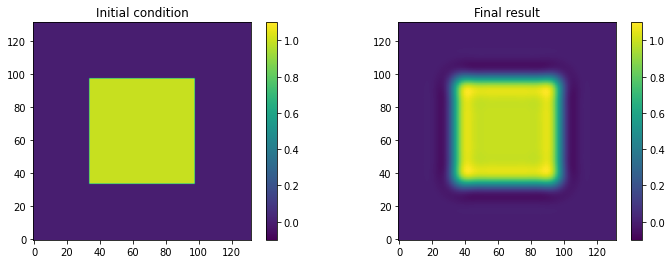

In [38]:
validate_results()

## Parallelization of the j-loop

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>5.</b> Make a copy of the <tt>stencil2d-kparallel.F90</tt> program and name it <tt>stencil2d-jparallel.F90</tt>. This time use OpenMP to parallelize the <tt>j</tt>-loop. Make sure to remove the <tt>k</tt>-loop parallelization. Compile it and run it. How fast is your code? What would you have expected?<br>
<b>6.</b> Again generate a report. What changed? Can you use the report to explain your findings above?<br>
<b>7.</b> Is it a good idea to try and parallelize the <tt>i</tt>-loop? Why?<br>
</div>

In [51]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=jparallel

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-jparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-jparallel.o -o stencil2d-jparallel.x
cp stencil2d-jparallel.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-jparallel.x' (lite-samples) ...OK


In [52]:
%%bash
srun -n 1 ./stencil2d-jparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024

# threads =           24
# ranks nx ny ny nz num_iter time
data = np.array( [ \
[    1,  128,  128,   64,    1024,  0.1477672E+01], \
] )


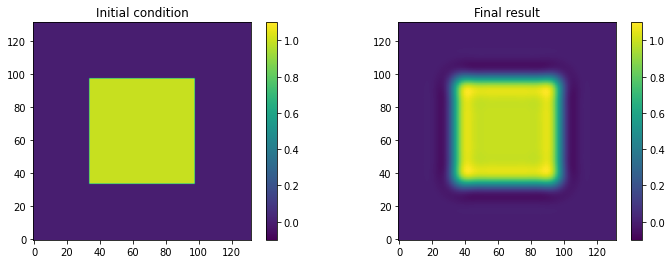

In [53]:
validate_results()

In [46]:
%%bash
srun -n 1 ./stencil2d-jparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024 > report_jparallel.txt

CrayPat/X:  Version 7.1.1 Revision 7c0ddd79b  08/19/19 16:58:46


<b>2.</b> Run you code using just 1 thread. How does the runtime compare against the base version? Run the both versions of the code several times to make sure the result is reproducible. What could be the reason for the difference?<br>

## Setting the number of threads

We now know that we have 12 cores availiable on the CPU. We want to investigate what the best number of threads is. While it is possible to increase the number of threads beyond the number of cores (in fact the default value we found above is 24, giving 2 threads per core), there probably is an optimum.

The thread number can be set 

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>8.</b> Use the <tt>stencil2d-kparallel.F90</tt> version of the code you developed above and find the optimal number of threads.<br>
<b>9.</b> Do the same thing for the version where you have parallelized the j-loop.
</div>

In [45]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make clean
make VERSION=kparallel

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp -c stencil2d-kparallel.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -h omp m_utils.o stencil2d-kparallel.o -o stencil2d-kparallel.x
cp stencil2d-kparallel.x stencil2d.x


INFO: creating the CrayPat-instrumented executable 'stencil2d-kparallel.x' (lite-samples) ...OK


In [54]:
%%bash
echo "out = [None] * 31" > out.txt
for nthreads in `seq 1 30` ; do
  export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads
  if [ $nthreads -gt 24 ] ; then
    ncores=24
  fi
  srun -n 1 -c $ncores ./stencil2d-kparallel.x+orig --nx 128 --ny 128 --nz 64 --num_iter 1024 | sed "s/data =/out[$nthreads] =/g" >> out.txt
done

oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
srun: Job 23096447 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 23096447
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print detailed thread-affinity messages.
oversubscription of available CPU resources!  Performance may be degraded.
Explicitly set OMP_WAIT_POLICY=PASSIVE or ACTIVE to suppress this message.
Set CRAY_OMP_CHECK_AFFINITY=TRUE to print 

In [55]:
exec(open('out.txt','r').read())
labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:,5].item())

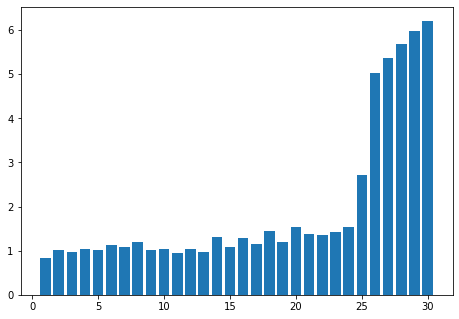

In [56]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels, times)
plt.show()

### Collapsing loops and fixing the number of threads

OpenMP allows you to parallelize over two loops instead of just one. How does `omp parallel for collapse (2)` compare to these options?

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>2.</b> We compare collapsing loops to having one or two parallel for loops<br>
<dd>a) only parallelize the j loop<br></dd>
<dd>b) collapse the two<br></dd>
<dd>c) take the ij paralellization from above<br></dd>
</div>

In [ ]:
%%bash
# implement a version that parallelizes j first
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=jparallel

In [ ]:
%%bash --out jparallel
srun -n 12 ./stencil2d-jparallel.x --nx 128 --ny 128 --nz 64 --num_iter 1024

In [ ]:
%%bash
# implement a version that collapses the loops
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=collapse

In [ ]:
%%bash --out collapse
srun -n 12 ./stencil2d-collapse.x --nx 128 --ny 128 --nz 64 --num_iter 1024

In [ ]:
## remove this once the implementation is done
collapse = base_code
jparallel = base_code

In [ ]:
labels = ['collapse', 'jparallel', 'ijparallel']
times = []
# fetch all the times
exec(collapse)
times.append(data[0,5])
exec(jparallel)
times.append(data[0,5])
exec(ijparallel)
times.append(data[0,5])

# some plotting magic
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,times)
plt.show()

## Scheduling

We use the optimal number of threads `p` moving forward
OpenMP allows for a schedule to be set. Try experimenting what the best schedule is between:
```
static(1)
static(nz/p)
dynamic(1)
dynamic(nz/p)
dynamic(nz/p/2)
guided
```

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> We find the best schedule for our loop, switch between the options above to find the best strategy<br>
   <b>4.</b> Reason why this is the optimal strategy
</div>

## Parallelizing the Halo updated

The halo updates are a set of small loops that are all independent. This leads to using the `nowait` pragma ideally.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>5.</b> Implement the parallelization of the halo updates<br>
<b>6.</b> Reason why the performance benefit is what you see
</div>

In [ ]:
%%bash
# play with the number of threads
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray
module load perftools-lite

make VERSION=parallelHalo

In [ ]:
%%bash --out parallelHalo
# make sure to set the number of threads to the optimal number
srun -n 12 ./stencil2d-parallelHalo.x --nx 128 --ny 128 --nz 64 --num_iter 1024 --num_threads 24

# Bonus exercises

If you have enough time, there are three additional tasks of higher difficulty to refine some skills

### Manual implementation of the omp parallel for pragma
There is a way to re-implement what a parallel for loop does with the directives `omp parallel`, `omp single`(or similar) and `omp task`. See if you manage to parallelize just the k loop of the code without using `omp parallel for`. What are the performance implications? Why?

### Fusing the computation loops

Currently we have the computation in two ij loops. Ideally we would have the computation in just one loop.

There is a way to fuse the compuatational loops (and have the update on a separate loop). 

What are performance benefits of this?

*cleanup in the end*

In [ ]:
%%bash
make clean
rm -rf in_field.dat out_field.dat